## Import Modules

In [28]:
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from shapely import Polygon, intersection, union
from skimage.measure import find_contours
import os

## Read Image

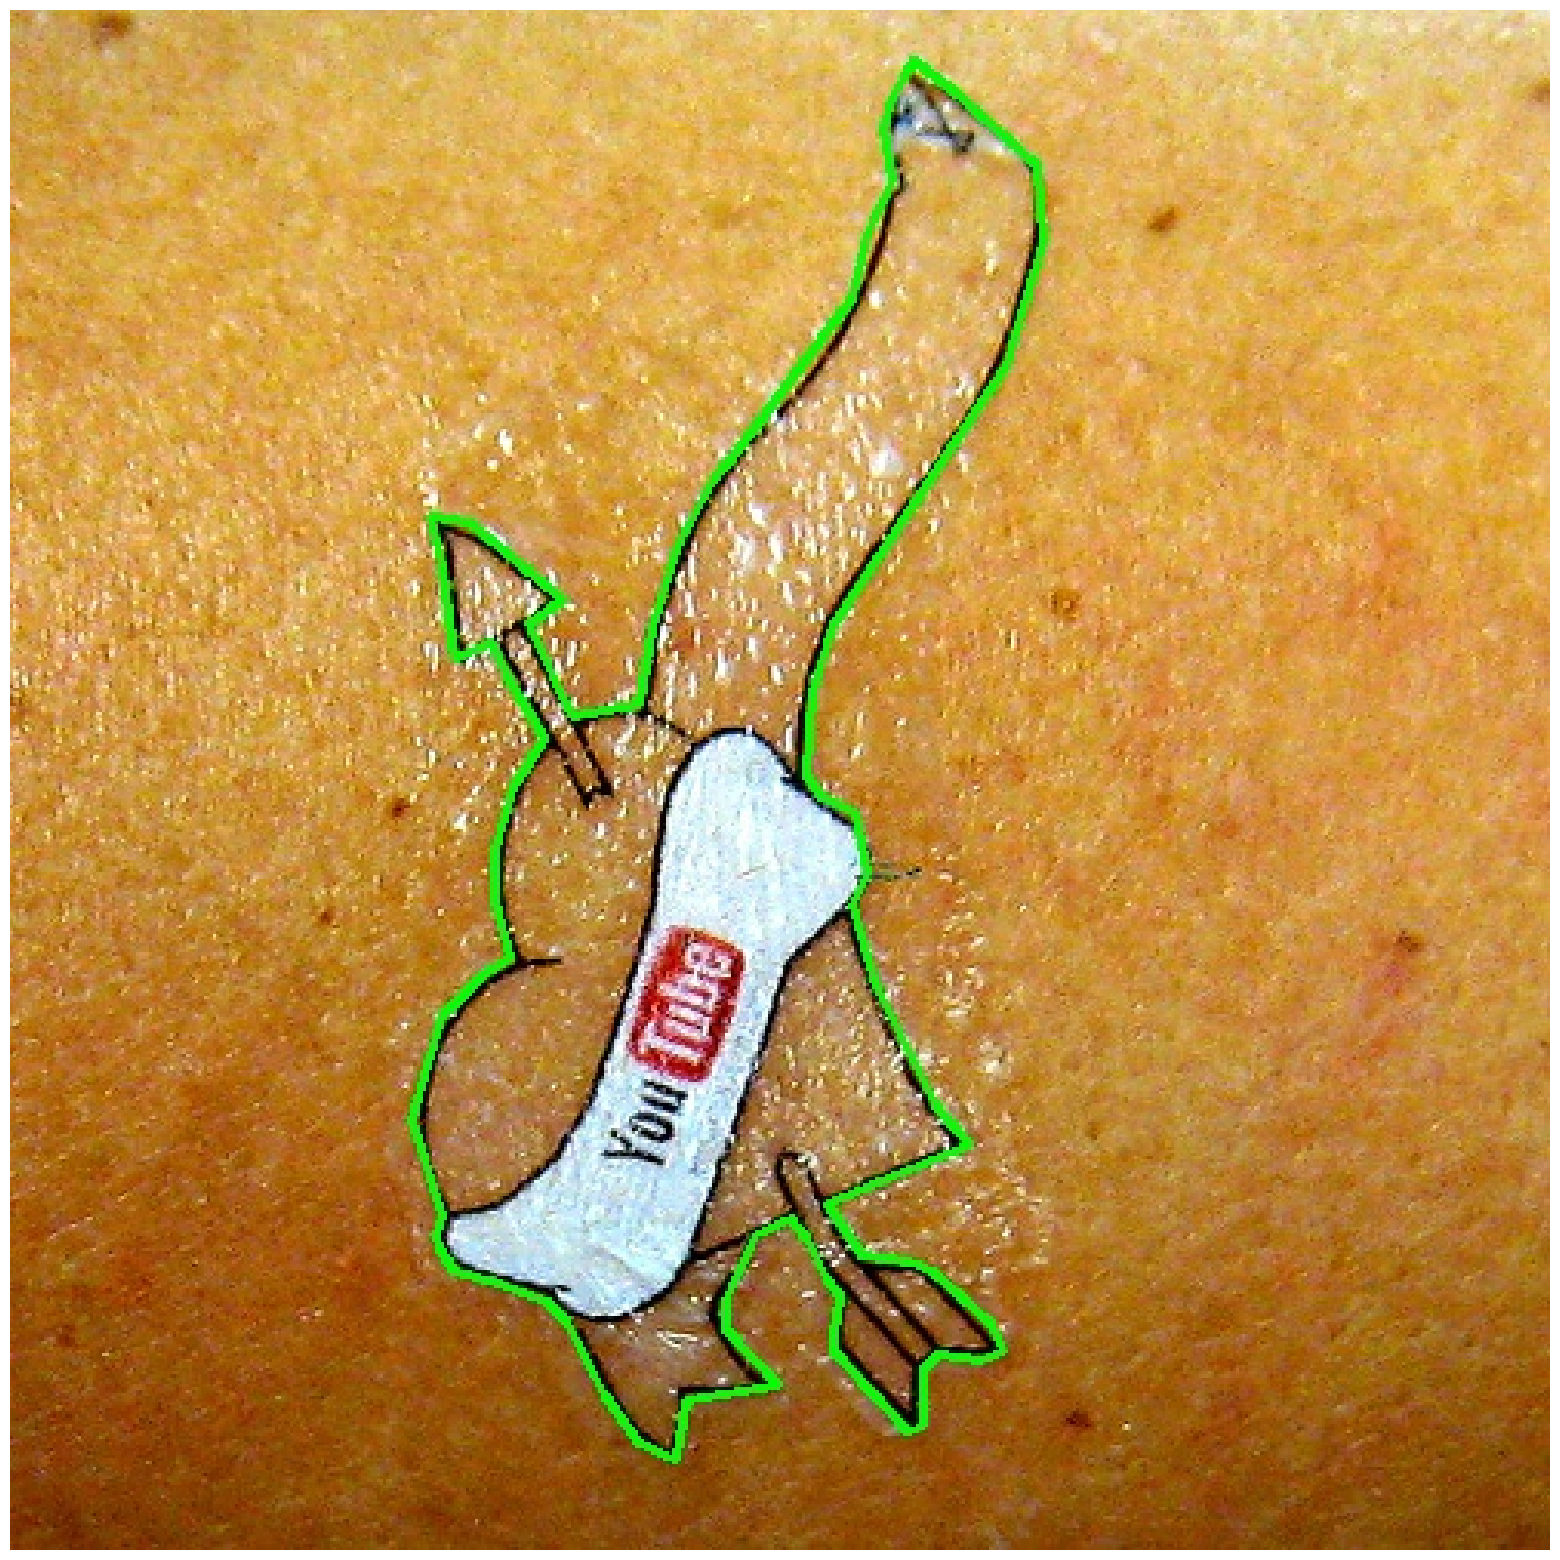

In [20]:
image = cv2.imread("./Polygon.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#cv2.rectangle(image,)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.savefig("test.jpg")

## Data Cleaning

In [3]:
annotation_file = "../tattoo_annotations.txt"
annotations = []
match_pattern =r'(.+\.jpg) (\[.+\])'
split_pattern = r'[;\s\t\n\]]'
result = {}
with open(annotation_file) as file:
    for input_str in file.readlines():
        match = re.match(match_pattern, input_str)
        if match:
            filename = match.group(1)
            coordinates_str = match.group(2)
            coordinates_list = re.split(split_pattern, coordinates_str)
            coordinates_list = [x.strip(r"\[\]") for x in coordinates_list if x != ""]
            result[filename] = coordinates_list
        else:
            print("No matches!")

## Evaluate Strings

In [8]:
results_evaluated = {}
for k,v in result.items():
    results_evaluated[k] = [eval(x) for x in v]


In [47]:
#p = results_evaluated["4786652878_b7821697f4.jpg"]
dirlist = os.listdir("../tattoo_images")
keylist = results_evaluated.keys()
for file in dirlist:
    if file not in keylist:
        print(file)
print(len(keylist))

2500202863_6161942693.jpg
2650208469_6178fe767a.jpg
3008716101_fa4dc47e2b.jpg
3108264669_1642be4433.jpg
3234080054_e156d851b8.jpg
3256315817_05fcb358b6.jpg
3658150919_02f3e8f357.jpg
3658194094_f4ef5bbac5.jpg
3660653086_3ef0c645f4.jpg
366720358_2efa686d76.jpg
3668148661_68fa184f59.jpg
367155901_62632062d6.jpg
3674359533_0c04b1dd58.jpg
3674828575_b883c035fb.jpg
367534909_d3dcaba2ea.jpg
36756807_7718518f91.jpg
3677203611_dec1cefb3b.jpg
3679514517_d830560f7e.jpg
3679642225_83b367bc3c.jpg
368748953_861006ae00.jpg
3688832271_3c18766f9a.jpg
3688832293_13c2fd70f3.jpg
3695983005_85cdf1d9f8.jpg
3697942349_996497aec5.jpg
3699404078_2791988929.jpg
3703274575_8306f14cab.jpg
3703780858_74b0d7c636.jpg
3703841694_3a02cabfd7.jpg
3705076863_237c197729.jpg
370508297_70e7e3695c.jpg
3705907825_4b7af058c1.jpg
3706744404_eca55235a4.jpg
3707213446_86b503d77e.jpg
3708491002_1546837f91.jpg
3713123862_25758e3ef2.jpg
3713875559_89013e61a1.jpg
3720141084_fdf63a709a.jpg
3720333430_9c9e6f5e9b.jpg
3720333432_c2b3c470

## Write Polygon

In [14]:
points = results_evaluated["2776427893_58405d2a94.jpg"]
points = [tuple(int(value) for value in original_tuple) for original_tuple in points]
for point in points:
    cv2.polylines(image, [np.array(points)], isClosed=False, color=(0, 255, 0), thickness=2)
cv2.imshow("Image with points", image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("Polygon.jpg", image)

True

## Create Masks

In [21]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["default"](checkpoint="D:/Documents/AAA_Hochschule/SoSe_24/Biometrics/sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

## Show Masks

In [25]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [22]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

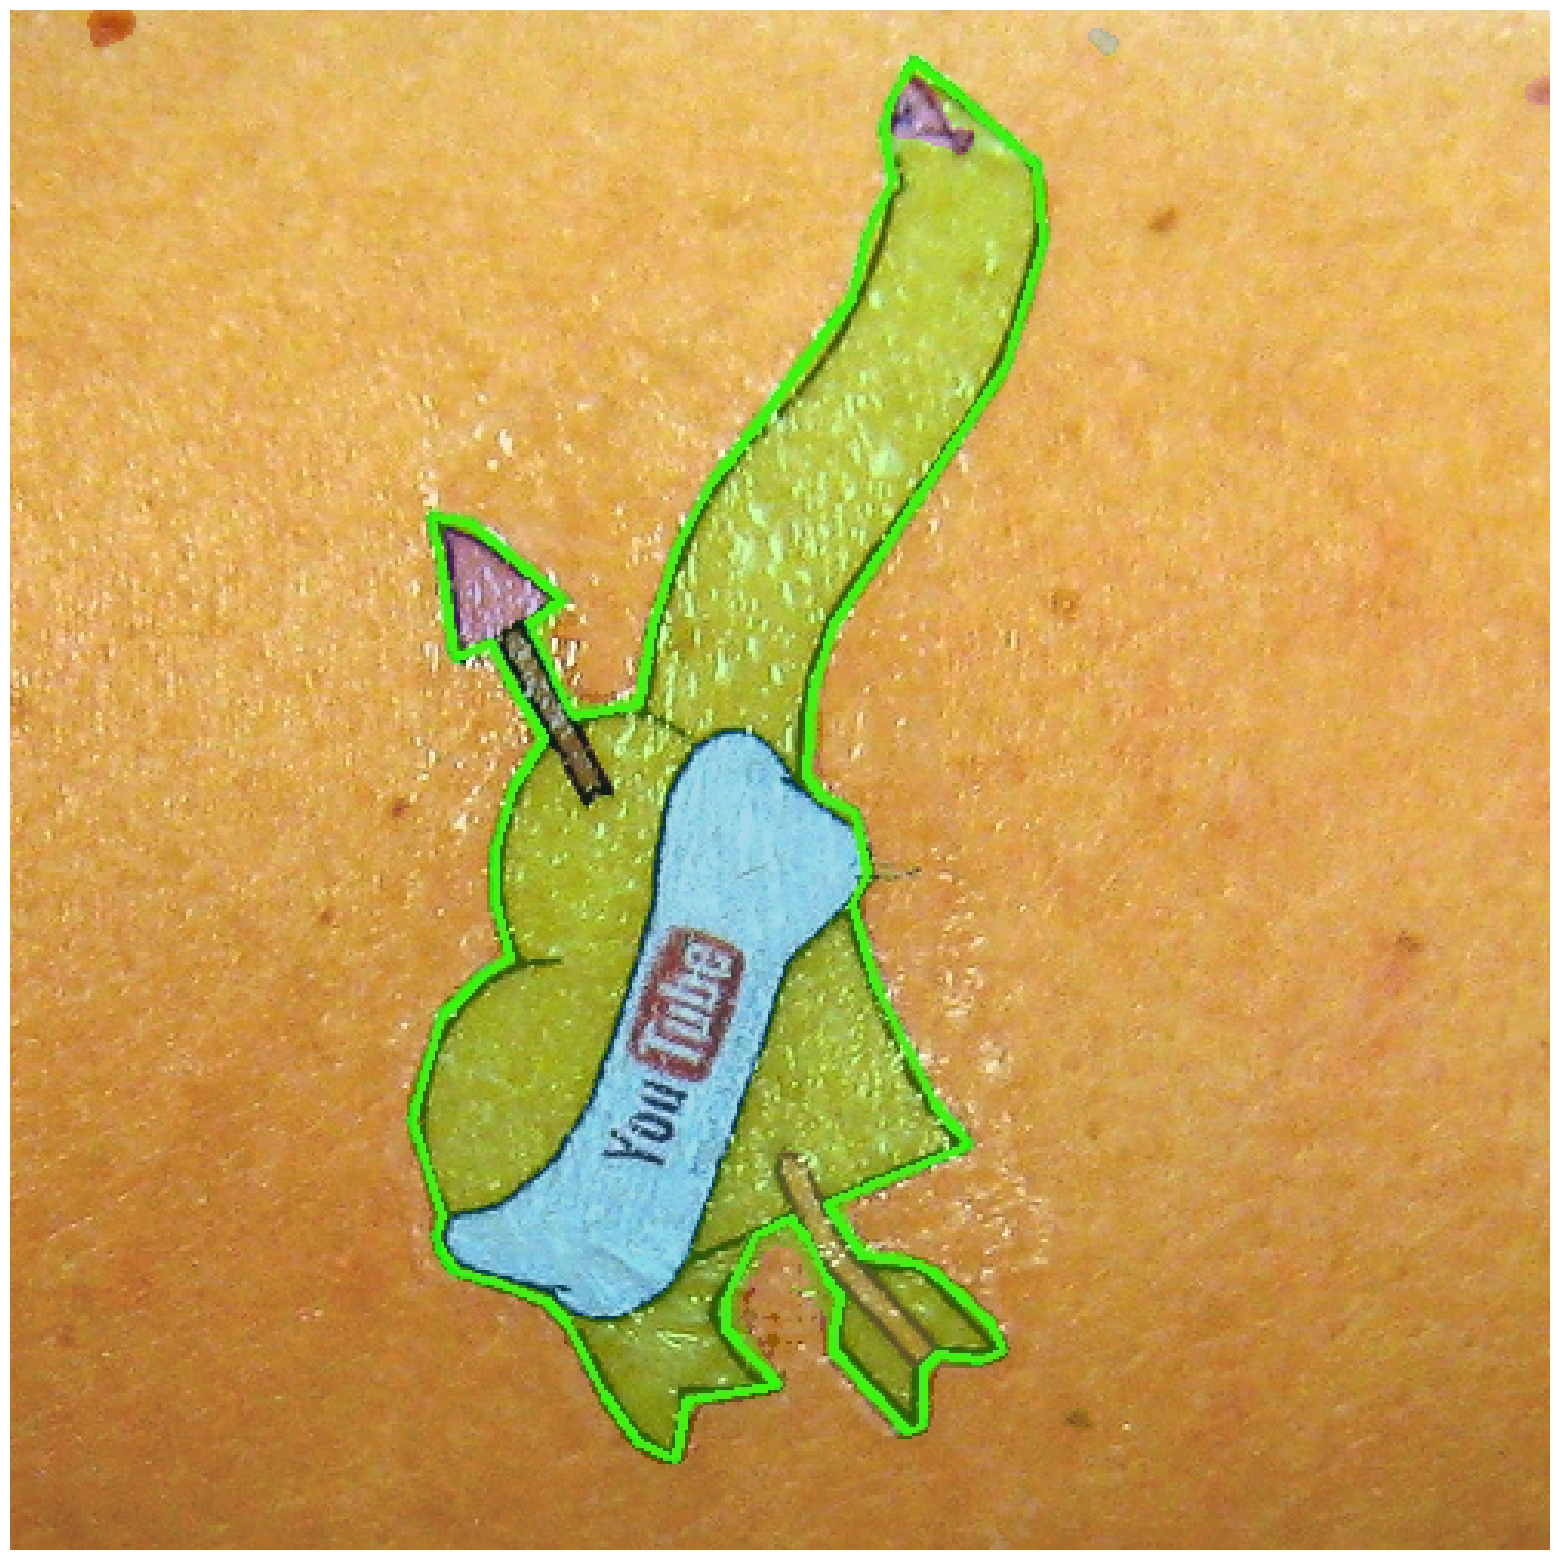

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [58]:
points = results_evaluated["2776427893_58405d2a94.jpg"]
x_max, x_min, y_max, y_min = 0,1000,0,1000
for pair in points:
    if pair[0] > x_max:
        x_max = pair[0]
    elif pair[0] < x_min:
        x_min = pair[0]
    elif pair[1] > y_max:
        y_max = pair[1]
    elif pair[1] < y_min:
        y_min = pair[1]
box =  np.array([x_min, y_min, x_max, y_max])
box

array([130.75196408,  16.88509646, 335.57800224, 470.90657904])

In [228]:
for m in masks:
    print(m["segmentation"][350])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def mask_to_image(image, mask):
    """
    Apply binary mask to the image and set False areas to black.

    Args:
    image (numpy.ndarray): The original image.
    mask (numpy.ndarray): Binary mask indicating areas to keep.

    Returns:
    numpy.ndarray: Processed image.
    """
    # Copy the original image to avoid modifying it directly
    processed_image = np.copy(image)

    # Set False areas to black
    processed_image[~mask] = 0

    return processed_image

# Example usage:
# Assuming you have your binary mask as 'binary_mask' and your original image as 'original_image'
# Create some sample data for demonstration
binary_mask = np.random.choice([True, False], size=(100, 100))

# Convert binary mask to image
processed_image = mask_to_image(image,masks[0]['segmentation'])

# Display original and processed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap='gray')
plt.title('Processed Image')
plt.axis('off')
plt.show()



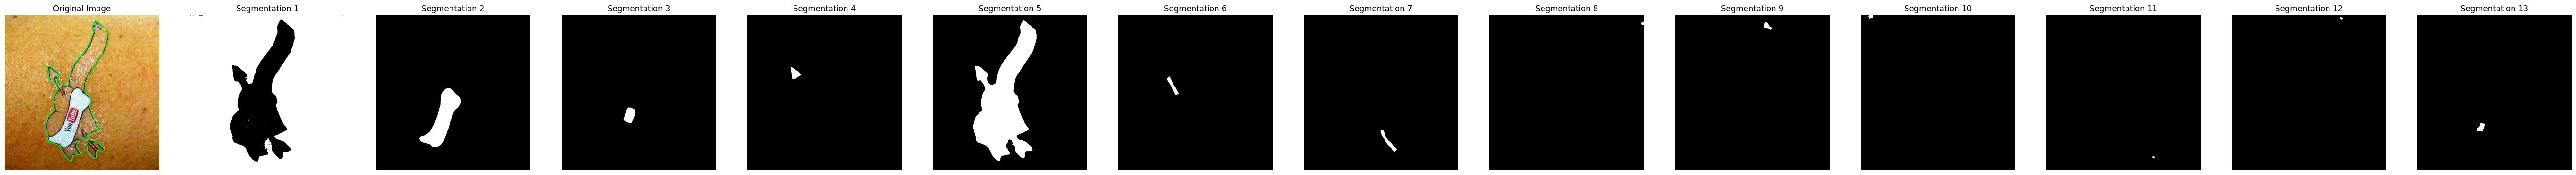

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def mask_to_image(image, mask):
    """
    Apply binary mask to the image and set False areas to black.

    Args:
    image (numpy.ndarray): The original image.
    mask (numpy.ndarray): Binary mask indicating areas to keep.

    Returns:
    numpy.ndarray: Processed image.
    """
    # Copy the original image to avoid modifying it directly
    processed_image = np.copy(image)

    # Set False areas to black
    processed_image[~mask] = 0

    return processed_image

def plot_segmentations(original_image, segmentations, titles):
    """
    Plot the original image along with multiple segmented images.

    Args:
    original_image (numpy.ndarray): The original image.
    segmentations (list of numpy.ndarray): List of segmented images.
    titles (list of str): Titles for each segmented image.
    """
    num_segmentations = len(segmentations)
    num_plots = num_segmentations + 1  # Include original image

    plt.figure(figsize=(5 * num_plots, 5))

    # Plot the original image
    plt.subplot(1, num_plots, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Plot each segmented image
    for i in range(num_segmentations):
        plt.subplot(1, num_plots, i + 2)
        plt.imshow(segmentations[i], cmap="grey")
        plt.title(titles[i])
        plt.axis('off')

    plt.show()

# Example usage:
# Assuming you have your original image as 'original_image' and a list of binary masks as 'segmentation_masks'
# Also assuming you have a list of titles for each segmentation mask as 'segment_titles'

# Create some sample data for demonstration
num_segmentations = len(masks)
segment_titles = [f'Segmentation {i+1}' for i in range(num_segmentations)]

# Convert binary masks to images
segmented_images = [mask['segmentation'] for mask in masks]

# Plot original image and segmented images
plot_segmentations(image, segmented_images, segment_titles)


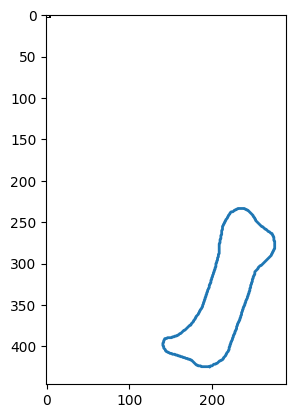

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon


# Find contours
contours = find_contours(masks[1]["segmentation"], 0.5)

# Plot the binary mask
plt.imshow(binary_mask, cmap='gray')

# Plot each contour as a polygon
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.axis('image')
plt.show()


In [160]:
contours[0]

array([[471. , 217.5],
       [470. , 217.5],
       [469.5, 218. ],
       ...,
       [471.5, 216. ],
       [471.5, 217. ],
       [471. , 217.5]])

In [220]:
def calculate_iou(polygon1, polygon2):
    polygon1 = Polygon(polygon1)
    polygon2 = Polygon(polygon2)

    intersection_area = intersection(polygon1, polygon2).area
    union_area = union(polygon1, polygon2).area

    iou = intersection_area/union_area

    return iou
for mask in masks:
    contours = find_contours(mask["segmentation"], 0.5)
    '''if len(contours) > 1:
        print(len(contours))
        print("No")
    else:'''
    print(calculate_iou(points, contours[0]))

#intersection(Polygon(points), Polygon(find_contours(masks[0]["segmentation"])[0]))





0.11339823150814324
0.022931095578158252
0.0
0.0
0.01094088660813381
0.0
0.0
0.0
0.0
0.0
0.0
0.005487085274901756
0.0
0.0


POLYGON ((72.5 375, 72.5 374, 72.5 373, 72.5 372, 72.5 371, 72 370.5, 71.5 370, 71.5 369, 71 368.5, 70.5 368, 70 367.5, 69 367.5, 68.5 368, 68 368.5, 67 368.5, 66.5 369, 66 369.5, 65.5 370, 65 370.5, 64.5 371, 64.5 372, 64 372.5, 63.5 373, 63.5 374, 63 374.5, 62.5 375, 62.5 376, 62.5 377, 62.5 378, 63 378.5, 63.5 379, 64 379.5, 64.5 380, 65 380.5, 66 380.5, 67 380.5, 67.5 380, 68 379.5, 69 379.5, 69.5 379, 70 378.5, 70.5 378, 71 377.5, 71.5 377, 71.5 376, 72 375.5, 72.5 375))
POLYGON ((216 470, 219 451, 249 446, 232 428, 232 418, 242 397, 253 392, 258 398, 265 412, 269 417, 267 430, 267 435, 291 461, 292 461, 296 459, 296 441, 301 436, 315 438, 322 435, 318 426, 299 409, 292 406, 276 404, 265 387, 311 368, 300 355, 281 317, 273 290, 278 280, 274 260, 263 255, 258 248, 260 221, 267 199, 301 148, 323 115, 335 75, 333 50, 305 25, 293 16, 290 21, 286 28, 283 38, 286 55, 278 72, 273 93, 237 141, 228 152, 217 172, 208 200, 204 225, 182 229, 168 199, 179 191, 149 166, 136 164, 140 180, 143 20

91.5